In [2]:
# ==========================================
#   Gender Gaps in Life Expectancy & Health
# ==========================================

from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------------------------------------
# 1. Auto-detect project root
# ------------------------------------------------
def find_project_root(marker="README.md"):
    cur = Path().resolve()
    while cur != cur.parent:
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    raise RuntimeError("Project root not found.")

ROOT = find_project_root()
DB_PATH = ROOT / "data" / "db" / "global_health_nutrition.db"

print("PROJECT ROOT:", ROOT)
print("DATABASE PATH:", DB_PATH)
print("DB Exists:", DB_PATH.exists())

PROJECT ROOT: F:\data-analysis_startup\global_health_nutrition_analysis
DATABASE PATH: F:\data-analysis_startup\global_health_nutrition_analysis\data\db\global_health_nutrition.db
DB Exists: True


In [3]:
# ------------------------------------------------
# 2. Load gender gap view
# ------------------------------------------------
conn = sqlite3.connect(DB_PATH)
df_gap = pd.read_sql_query("SELECT * FROM v_gender_gap_life_expectancy;", conn)
conn.close()

print("Rows loaded:", len(df_gap))
display(df_gap.head())

Rows loaded: 8430


,country,year,le_female,le_male,le_both,le_gap_female_minus_male
0,Afghanistan,1990.0,51.442,49.281,50.331,2.161
1,Afghanistan,1991.0,52.119,49.938,50.999,2.181
2,Afghanistan,1992.0,52.774,50.570,51.641,2.204
3,Afghanistan,1993.0,53.405,51.172,52.256,2.233
4,Afghanistan,1994.0,54.012,51.746,52.842,2.266


In [4]:
# ------------------------------------------------
# 3. Overview
# ------------------------------------------------
print("Shape:", df_gap.shape)
print("Columns:", df_gap.columns.tolist())
print("Years:", df_gap["year"].min(), "→", df_gap["year"].max())
print("Countries:", df_gap["country"].nunique())

Shape: (8430, 6)
Columns: ['country', 'year', 'le_female', 'le_male', 'le_both', 'le_gap_female_minus_male']
Years: 1990.0 → 2019.0
Countries: 281


In [5]:
# ------------------------------------------------
# 4. Latest year slice
# ------------------------------------------------
latest_year = df_gap["year"].max()
df_latest = df_gap[df_gap["year"] == latest_year].copy()

print(f"\nLatest year: {latest_year}, rows: {len(df_latest)}")
display(df_latest.head())


Latest year: 2019.0, rows: 281


,country,year,le_female,le_male,le_both,le_gap_female_minus_male
29,Afghanistan,2019.0,66.388,63.382,64.833,3.006
59,Africa,2019.0,64.978,61.383,63.170,3.595
89,Albania,2019.0,80.201,77.002,78.573,3.199
119,Algeria,2019.0,78.133,75.676,76.880,2.457
149,American Samoa,2019.0,NaN,NaN,73.745,NaN


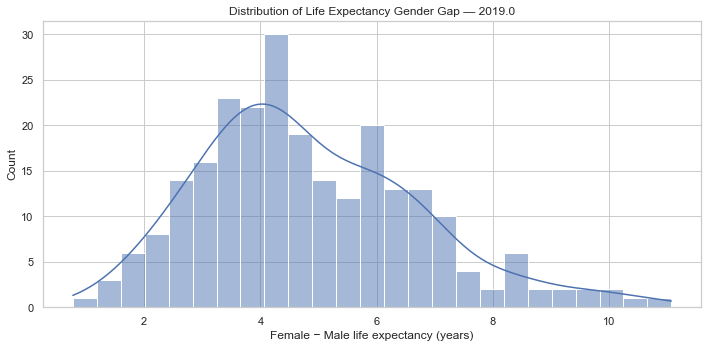

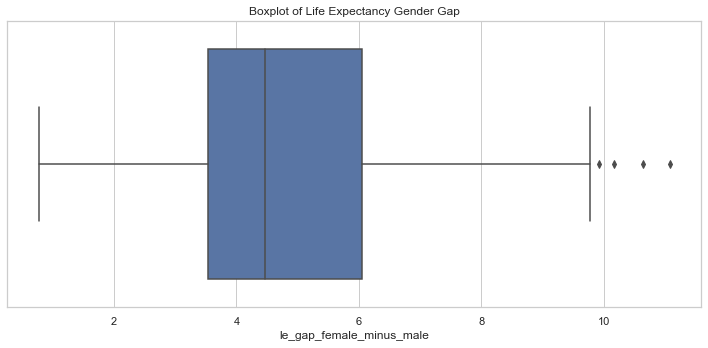

In [6]:
# ------------------------------------------------
# 5. Distribution of gender life expectancy gap
# ------------------------------------------------
if "le_gap_female_minus_male" in df_latest.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_latest["le_gap_female_minus_male"], kde=True, bins=25)
    plt.title(f"Distribution of Life Expectancy Gender Gap — {latest_year}")
    plt.xlabel("Female − Male life expectancy (years)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_latest["le_gap_female_minus_male"])
    plt.title("Boxplot of Life Expectancy Gender Gap")
    plt.tight_layout()
    plt.show()
else:
    print("Gender gap column not available in dataset.")

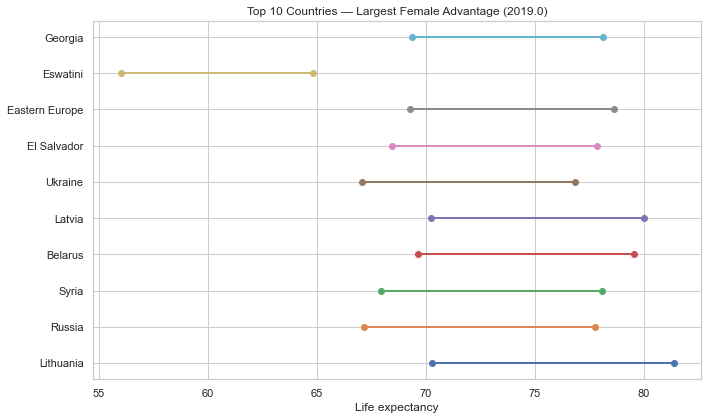

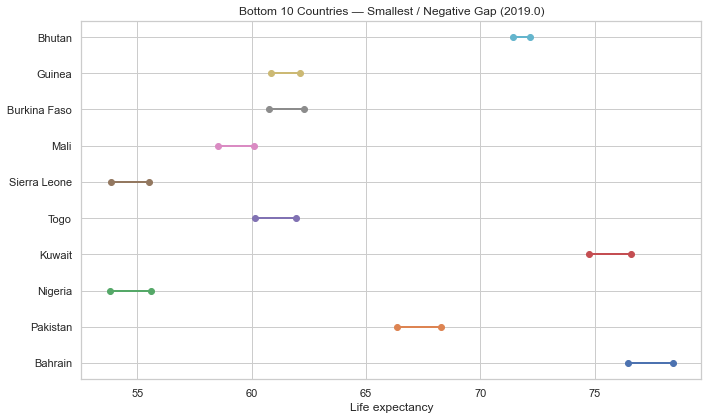

In [7]:
# ------------------------------------------------
# 6. Dumbbell chart (Top & Bottom 10 countries)
# ------------------------------------------------
if {"le_female", "le_male"}.issubset(df_latest.columns):
    df_sorted = df_latest.dropna(subset=["le_female", "le_male"]).sort_values(
        "le_gap_female_minus_male", ascending=False
    )

    top10 = df_sorted.head(10)
    bottom10 = df_sorted.tail(10)

    def dumbbell_plot(data, title):
        plt.figure(figsize=(10, 6))
        for _, row in data.iterrows():
            plt.plot([row["le_male"], row["le_female"]], [row["country"], row["country"]], "o-", linewidth=2)
        plt.title(title)
        plt.xlabel("Life expectancy")
        plt.tight_layout()
        plt.show()

    dumbbell_plot(top10, f"Top 10 Countries — Largest Female Advantage ({latest_year})")
    dumbbell_plot(bottom10, f"Bottom 10 Countries — Smallest / Negative Gap ({latest_year})")
else:
    print("Skipping dumbbell charts — missing male/female life expectancy columns.")

Skipping scatter: gdp_per_capita vs le_gap_female_minus_male (missing columns)


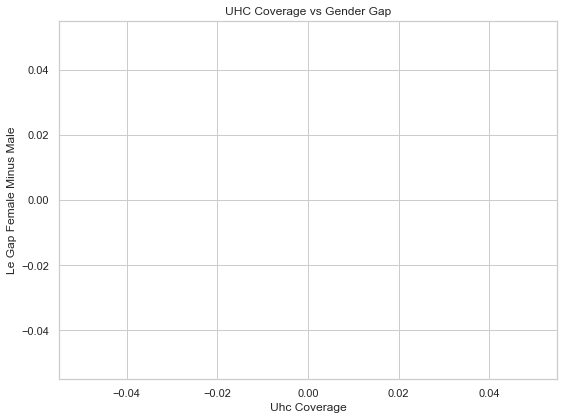

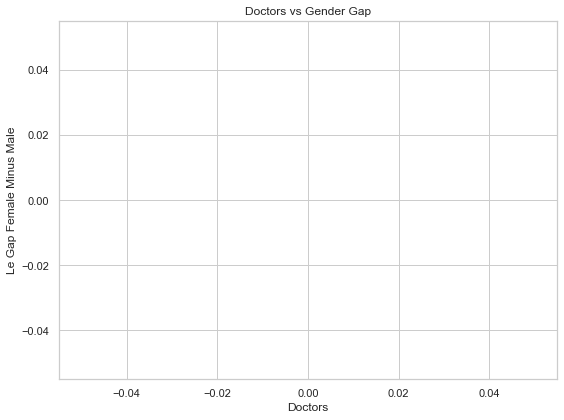

In [8]:
# ------------------------------------------------
# 7. Gender gap vs GDP or healthcare access (if available)
# ------------------------------------------------
if {"le_gap_female_minus_male"}.issubset(df_latest.columns):
    # Load health access data
    conn = sqlite3.connect(DB_PATH)
    df_access = pd.read_sql_query("SELECT * FROM v_health_access;", conn)
    conn.close()

    df_merged = df_latest.merge(df_access, on=["country", "year"], how="left")

    def safe_scatter(x, y, title):
        if {x, y}.issubset(df_merged.columns):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df_merged, x=x, y=y)
            plt.xlabel(x.replace("_", " ").title())
            plt.ylabel(y.replace("_", " ").title())
            plt.title(title)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping scatter: {x} vs {y} (missing columns)")

    safe_scatter("gdp_per_capita", "le_gap_female_minus_male", "GDP vs Gender Gap")
    safe_scatter("uhc_coverage", "le_gap_female_minus_male", "UHC Coverage vs Gender Gap")
    safe_scatter("doctors", "le_gap_female_minus_male", "Doctors vs Gender Gap")
else:
    print("Skipping gender gap vs access — core gap column missing.")


Time-series for Japan


,country,year,le_female,le_male,le_both,le_gap_female_minus_male
3600,Japan,1990.0,81.888,75.943,79.004,5.945
3601,Japan,1991.0,82.107,76.079,79.180,6.028
3602,Japan,1992.0,82.327,76.209,79.355,6.118
3603,Japan,1993.0,82.554,76.343,79.536,6.211
3604,Japan,1994.0,82.793,76.487,79.727,6.306


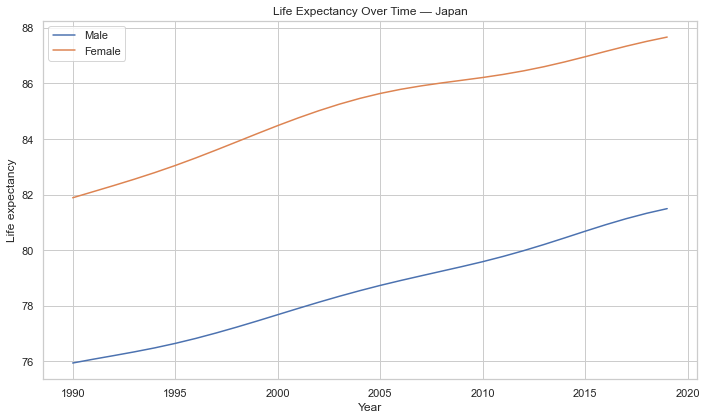

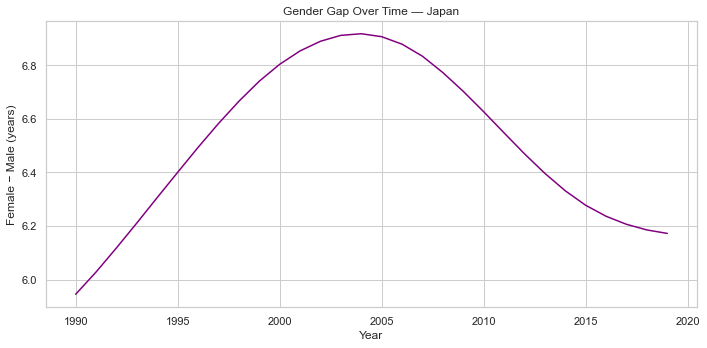

In [9]:
# ------------------------------------------------
# 8. Time-series example (choose a country)
# ------------------------------------------------
example_country = "Japan"  # change for storytelling

if example_country in df_gap["country"].unique():
    df_country = df_gap[df_gap["country"] == example_country].sort_values("year")

    print(f"\nTime-series for {example_country}")
    display(df_country.head())

    if {"le_male", "le_female"}.issubset(df_country.columns):
        plt.figure(figsize=(10, 6))
        plt.plot(df_country["year"], df_country["le_male"], label="Male")
        plt.plot(df_country["year"], df_country["le_female"], label="Female")
        plt.title(f"Life Expectancy Over Time — {example_country}")
        plt.ylabel("Life expectancy")
        plt.xlabel("Year")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if "le_gap_female_minus_male" in df_country.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(df_country["year"], df_country["le_gap_female_minus_male"], color="purple")
        plt.title(f"Gender Gap Over Time — {example_country}")
        plt.ylabel("Female − Male (years)")
        plt.xlabel("Year")
        plt.tight_layout()
        plt.show()
else:
    print(f"Country '{example_country}' not found in dataset.")